In [1]:
using PyPlot, FileIO, AnomalyDetection, EvalCurves, Flux
import PyPlot: plot
include("./plots.jl")

┌ Info: Precompiling AnomalyDetection [2069a70b-aa58-5cc0-a11c-32e347b774c5]
└ @ Base loading.jl:1187
┌ Info: Precompiling FluxExtensions [76425322-8995-11e8-0106-93ec95767fb2]
└ @ Base loading.jl:1187


loaded


PyPlot.plot

In [2]:
# load data
dataset = load("toy_data_3.jld2")["data"]
#dataset = load("moon.jld")["data"]
X = AnomalyDetection.Float.(dataset.data)
Y = dataset.labels
nX = X[:, Y.==0]

2×90 Array{Float32,2}:
 0.803442  0.804605  0.807145  0.819485  …  0.0350314  0.0613807  0.0685027
 0.821998  0.834235  0.826129  0.848182     0.973926   1.00745    0.973256 

In [3]:
# VAE settings
indim = size(X,1)
hiddendim = 10
latentdim = 2
nlayers = 2

# setup the VAE object
variant = :sigma
    # :unit - output has unit variance
    # :sigma - the variance of the output is estimated
esize = [indim; hiddendim; hiddendim; latentdim*2] # encoder architecture
# decoder architecture
(variant == :unit) ? dsize = [latentdim; hiddendim; hiddendim; indim] :
    dsize = [latentdim; hiddendim; hiddendim; 2*indim]
lambda = 1e-3 # KLD weight in loss function
threshold = 0 # classification threshold, is recomputed using setthreshold!()
contamination = size(Y[Y.==1],1)/size(Y, 1) # for automatic threshold computation
iterations = 2000
cbit = 500 # after this number of iteratiosn, callback is printed
batchsize = 50 # batchsize 
nepochs = Int(ceil(batchsize*iterations/size(nX,2))) # if this is supplied, do epoch training
verbfit = true
M = 1 # reconstruction error samples, for training 1 is OK
# set low for training but high for classification
activation = Flux.relu
layer = Flux.Dense
rdelta = Inf # reconstruction error threshold for training stopping
Beta = 1.0 # for automatic threshold computation, in [0, 1] 
# 1.0 = tight around normal samples
tracked = true # do you want to store training progress?
# it can be later retrieved from model.traindata
eta = 0.001
model = VAEmodel(esize, dsize, lambda = lambda, threshold = threshold, 
    contamination = contamination, iterations = iterations, cbit = cbit, 
    nepochs = nepochs,
    verbfit = verbfit, batchsize = batchsize, M=M, activation = activation, 
    layer = layer, rdelta = rdelta, Beta = Beta, 
    tracked = tracked, variant = variant, eta = eta)

VAEmodel(VAE{Chain,typeof(AnomalyDetection.samplenormal),Chain,Val{:sigma}}(Chain(Dense(2, 10, NNlib.relu), Dense(10, 10, NNlib.relu), Dense(10, 4)), AnomalyDetection.samplenormal, Chain(Dense(2, 10, NNlib.relu), Dense(10, 10, NNlib.relu), Dense(10, 4)), Val{:sigma}()), 0.001, 0, 0.1262135922330097, 2000, 500, 1112, true, 50, 1, Inf32, 1.0f0, MVHistory{ValueHistories.History}, "likelihood", 0.001)

In [4]:
# fit the model
println("\ninitial loss")
AnomalyDetection.evalloss(model, nX)
@time AnomalyDetection.fit!(model, nX)
println("\nfinal loss")
AnomalyDetection.evalloss(model, nX)
AnomalyDetection.setthreshold!(model, X)


initial loss
loss: 0.07631988
likelihood: 0.06097317
KL: 0.066222034



Progress:   0%|                                         |  ETA: 4:49:38
  loss:        0.084078364
  likelihood:  0.1169162
Progress:  11%|█████                                    |  ETA: 0:01:06
  loss:        -2.4688706
  likelihood:  -2.465903
Progress:  20%|████████                                 |  ETA: 0:00:34
  loss:        -3.737189
  likelihood:  -3.8010077
Progress:  29%|████████████                             |  ETA: 0:00:22
  loss:        -4.5039935
  likelihood:  -4.648484
Progress:  38%|████████████████                         |  ETA: 0:00:15
  loss:        -5.058408
  likelihood:  -5.162588
Progress:  47%|███████████████████                      |  ETA: 0:00:11
  loss:        -4.9136868
  likelihood:  -5.0891166
Progress:  54%|██████████████████████                   |  ETA: 0:00:09
  loss:        -5.483887
  likelihood:  -5.584542
Progress:  62%|█████████████████████████                |  ETA: 0:00:06
  loss:        -5.543592
  likelihood:  -5.5088353
Progress:  70%|█

 13.507767 seconds (37.27 M allocations: 2.037 GiB, 5.52% gc time)

final loss
loss: -6.95992
likelihood: -7.0174975
KL: 20.797451



Progress: 100%|█████████████████████████████████████████| Time: 0:00:12
  loss:        -7.172902
  likelihood:  -7.1837616
  KL:          22.621344


-1.1847897f0

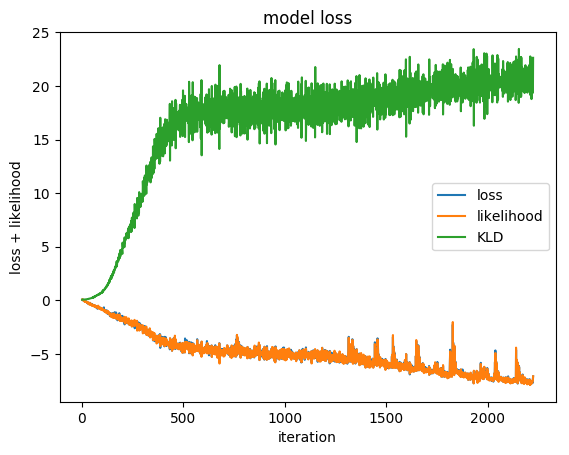

In [5]:
plot(model)
show()

How does the model reconstruct the normal data?

In [6]:
model(nX)

Tracked 4×90 Array{Float32,2}:
   0.798844    0.80124     0.802511  …   0.0181283   0.0437828   0.0576279
   0.810442    0.812876    0.814005      0.998102    0.986284    0.968108 
 -12.0378    -12.0627    -12.0759       -8.1369     -8.2443     -8.16988  
  -7.85951    -7.87671    -7.88579      -6.67485    -6.70353    -6.57648  

In [7]:
nX

2×90 Array{Float32,2}:
 0.803442  0.804605  0.807145  0.819485  …  0.0350314  0.0613807  0.0685027
 0.821998  0.834235  0.826129  0.848182     0.973926   1.00745    0.973256 

In [8]:
AnomalyDetection.mux(model, nX)

Tracked 2×90 Array{Float32,2}:
 0.799276  0.801316  0.802761  0.815947  …  0.032225  0.052643  0.0620416
 0.81141   0.813121  0.814169  0.825607     0.992428  0.996818  0.970702 

In [9]:
AnomalyDetection.sigma2x(model, nX)

Tracked 2×90 Array{Float32,2}:
 6.96045e-6   6.84124e-6   6.60282e-6   …  0.000268112  0.0002873 
 0.000387164  0.000381444  0.000375366     0.00125037   0.00138263

What are the parameters of $q(z|x)$?

In [10]:
AnomalyDetection.muz(model, nX)

Tracked 2×90 Array{Float32,2}:
 -6.56939  -6.58332  -6.59373  -6.67962  …  -2.16175  -2.30571  -2.30816
  2.2591    2.26833   2.26509   2.2906       1.64135   1.7132    1.71328

In [11]:
AnomalyDetection.sigma2z(model, nX)

Tracked 2×90 Array{Float32,2}:
 2.54972e-6   2.43051e-6   2.43051e-6   …  0.00253658  0.00187179  0.001885 
 0.000877281  0.000863584  0.000857509     0.0427347   0.0371662   0.0373185

What do the codes look like?

In [12]:
AnomalyDetection.sample_z(model, nX)

Tracked 2×90 Array{Float32,2}:
 -6.56754  -6.58381  -6.59651  -6.68029  …  -2.05863  -2.2421   -2.2769 
  2.27395   2.21423   2.3008    2.27221      1.8019    1.85013   1.60323

In [13]:
# predict labels on testing data
model.M = 10 # for classification higher is better (more stable)
tryhat = AnomalyDetection.predict(model, X)

103-element Array{Int64,1}:
 0
 0
 0
 0
 1
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 0
 1

In [14]:
# get the labels and roc stats
tryhat, tstyhat = AnomalyDetection.rocstats(dataset, dataset, model);


 Training data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 12
  tn = 89
  fp = 1
  fn = 1
precision: 0.9230769230769231
f1score: 0.9230769230769231
recall: 0.9230769230769231
false positive rate: 0.011111111111111112
equal error rate: 0.04401709401709402

 Testing data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 12
  tn = 89
  fp = 1
  fn = 1
precision: 0.9230769230769231
f1score: 0.9230769230769231
recall: 0.9230769230769231
false positive rate: 0.011111111111111112
equal error rate: 0.04401709401709402


In [15]:
# anomaly score contour plot
# get limits of the figure
xl = (minimum(X[1,:])-0.05, maximum(X[1,:]) + 0.05)
yl = (minimum(X[2,:])-0.05, maximum(X[2,:]) + 0.05)

# compute the anomaly score on a grid
x = range(xl[1], stop=xl[2], length=30)
y = range(yl[1], stop=yl[2], length=30)
zz = zeros(size(y,1),size(x,1))
for i in 1:size(y, 1)
    for j in 1:size(x, 1)
        zz[i,j] = AnomalyDetection.anomalyscore(model, AnomalyDetection.Float.([x[j], y[i]]))
    end
end

# also generate some samples
xgen = AnomalyDetection.generate(model, 30);

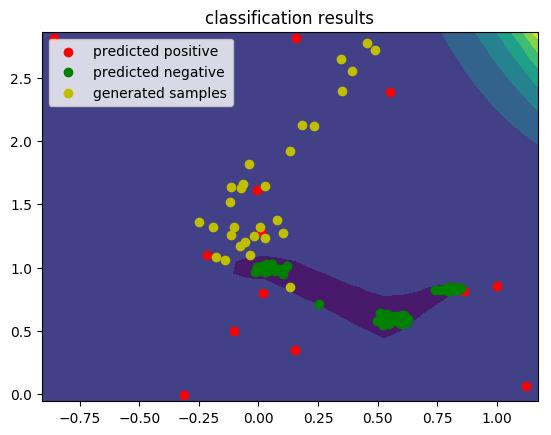

In [16]:
# plot it all
f = figure()
contourf(x, y, zz)
scatter(X[1, tryhat.==1], X[2, tryhat.==1], c = "r", 
    label = "predicted positive")
scatter(X[1, tryhat.==0], X[2, tryhat.==0], c = "g", 
    label = "predicted negative")
scatter(xgen[1,:], xgen[2, :], c = "y", 
    label = "generated samples")
title("classification results")
xlim(xl)
ylim(yl)
legend()
show()

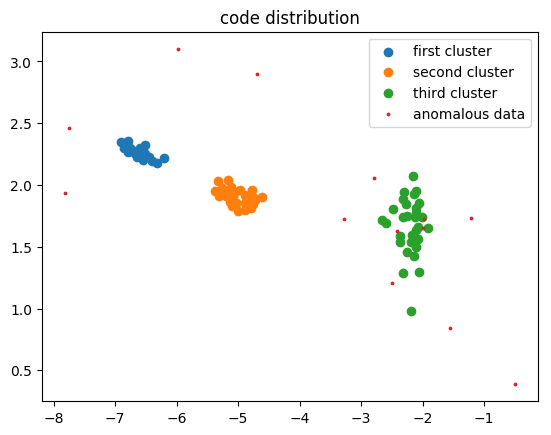

In [17]:
# what are the codes?
z1 = AnomalyDetection.getcode(model, X[:,1:30]).data
z2 = AnomalyDetection.getcode(model, X[:,31:60]).data
z3 = AnomalyDetection.getcode(model, X[:,61:90]).data
za = AnomalyDetection.getcode(model, X[:,91:end]).data

figure()
title("code distribution")
scatter(z1[1,:], z1[2,:], label = "first cluster")
scatter(z2[1,:], z2[2,:], label = "second cluster")
scatter(z3[1,:], z3[2,:], label = "third cluster")
scatter(za[1,:], za[2,:], s = 3, label = "anomalous data")
legend()
show()

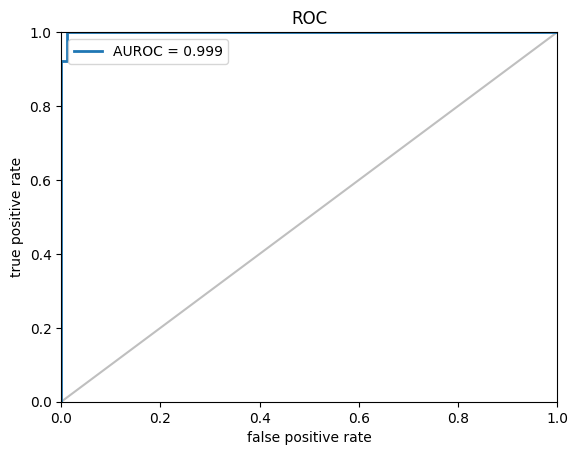

In [18]:
# plot ROC curve and compute AUROC score
ascore = AnomalyDetection.anomalyscore(model, X);
fprvec, tprvec = EvalCurves.roccurve(ascore, Y)
auroc = round(EvalCurves.auc(fprvec, tprvec),digits=3)
EvalCurves.plotroc((fprvec, tprvec, "AUROC = $(auroc)"))
show()